In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
f1 = '/playpen/Datasets/geodepth2/031/colon_geo_light/nr4/frame029645_disp.npy'
f2 = '/playpen/Downloads/joint/frame029645_disp.npy'

frame1 = np.load(f1)
frame2 = np.load(f2)
print(np.max(frame1), np.max(frame2))

6.641855 6.6418543


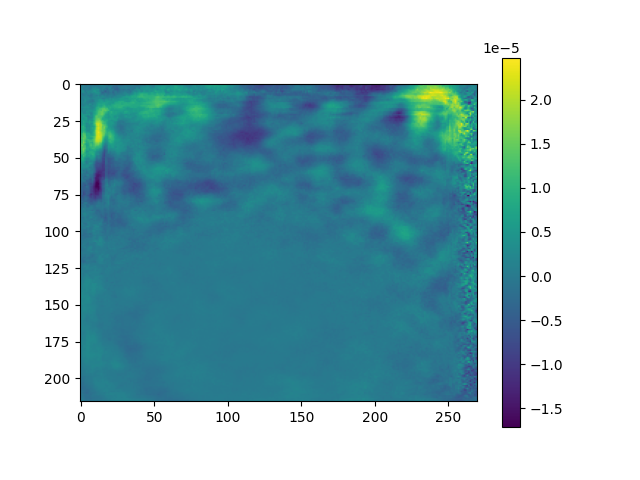

In [4]:
plt.imshow(frame2-frame1)
plt.colorbar()

In [5]:
name = '000'
number = '027'
normals = np.load(f'/playpen/Datasets/geodepth2/{name}/NFPS/images/{name}_{number}/{name}_{number}_nr_pred.npy')
print(np.min(normals), np.max(normals))
print(normals.shape)

-0.9999998 0.067828216
(216, 270, 3)


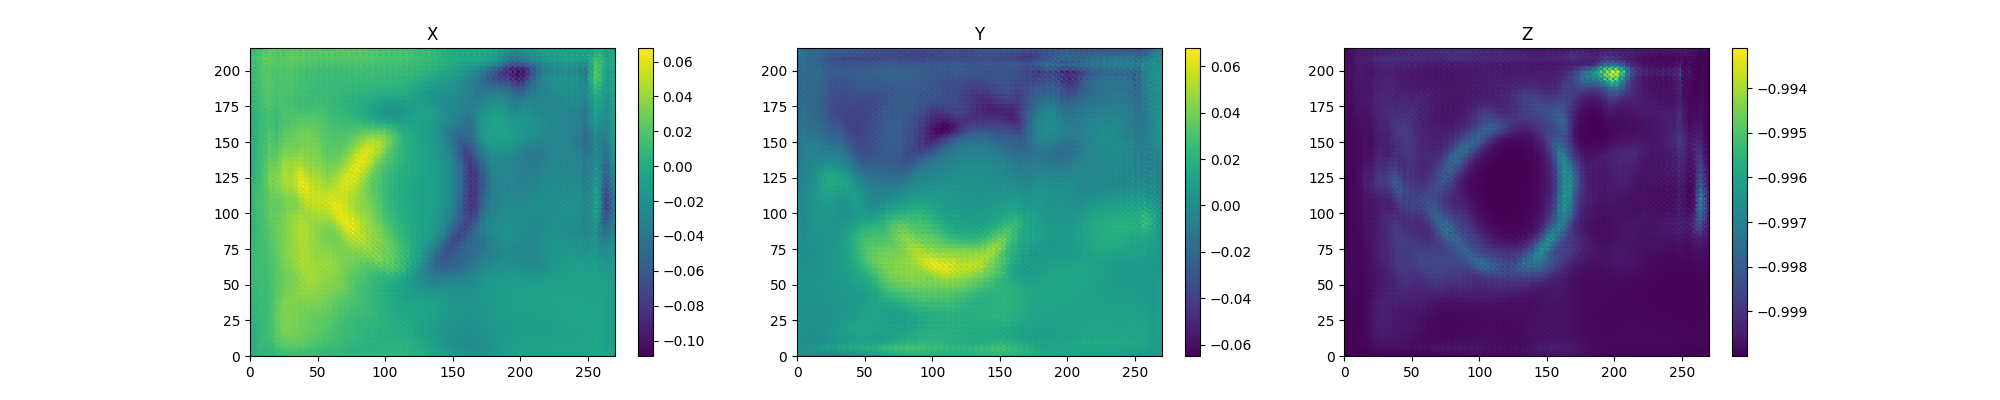

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(20,4))
for i in range(3):
    pc = ax[i].pcolor(normals[:,:,i])
    fig.colorbar(pc, ax=ax[i])
    ax[i].set_title(['X','Y','Z'][i])

(216, 270)
[ 0.01459193 -0.03153901 -0.9993846 ]


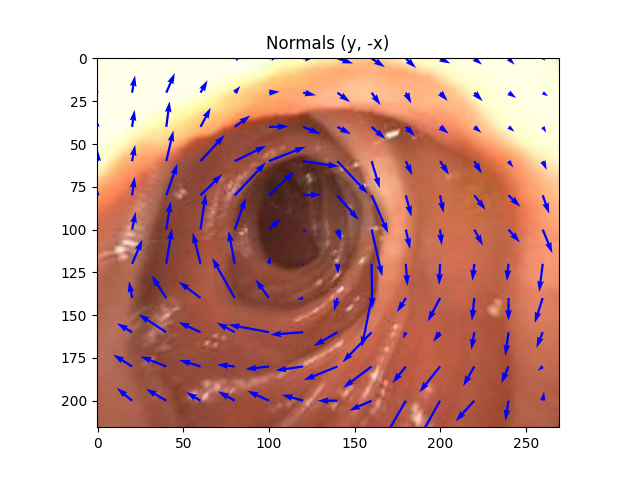

In [7]:
from skimage.io import imread
from glob import glob
from natsort import natsorted
%matplotlib widget

def quiver_image(ax, X, Y, xs, ys, **kwargs):
    ax.quiver(X, Y, xs, -ys, **kwargs)

frame = imread(natsorted(glob(f'/playpen/Datasets/geodepth2/{name}/image/*.jpg'))[int(number)])
frame_normals = frame.copy()
# normals_f = np.flip(normals, axis=1)
normals_f = normals.copy()
normals_f = np.transpose(normals_f, (2, 0, 1))
print(normals_f[1].shape)
# frame_normals[1] = np.abs(normals_f[1]*2550).astype(np.uint8)

X, Y = np.meshgrid(np.arange(0, normals_f.shape[2], 20), np.arange(0, normals_f.shape[1], 20), indexing='xy')

# plt.figure(figsize=(15,6))
# plt.subplot(131)
# plt.imshow(frame)
# plt.title('Frame')

# plt.subplot(133)
# plt.imshow(frame)
# plt.quiver(X, Y, normals_f[1][Y, X], normals_f[0][Y, X], color='blue')
# plt.title('Normals (y, x)')

plt.imshow(frame)
ax = plt.gca()
Q1 = quiver_image(ax, X, Y, normals_f[1][Y, X], -normals_f[0][Y, X], color='blue')
# Q2 = quiver_image(ax, X, Y, normals_f[0][Y, X], normals_f[1][Y, X], color='green')
# qk1 = ax.quiverkey(Q1, 0.9, 0.9, 0.1, 'arrow', labelpos='E', coordinates='figure')

plt.title('Normals (y, -x)')

print(normals_f[:,160,60])

(216, 270, 2)
[0 1]


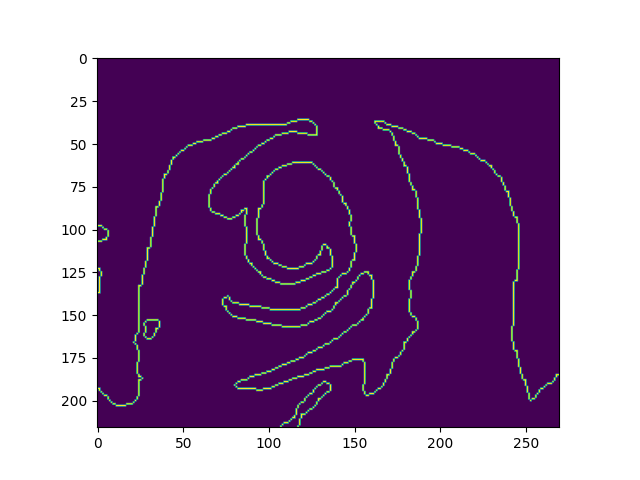

In [46]:
import skimage
import scipy
%matplotlib widget

field = np.stack((normals_f[1], -normals_f[0]), 2)
norms = np.linalg.norm(field, axis=2)
field[:,:,0] /= norms
field[:,:,1] /= norms
print(field.shape)

seg_img_file = f'/playpen/ridge-dtec/run/pascal/mobilenet4-96/ex_4_lucille/results-mine/{name}_frame031221.png'
seg_img = imread(seg_img_file)
seg_img = skimage.transform.resize(seg_img, field.shape[:2])
# plt.imshow(seg_img)

mask = seg_img[:,:,0]==0
mask = mask.astype(np.uint8)
# plt.imshow(mask)
# edges = skimage.feature.canny(mask).astype(np.uint8)
edges = mask - scipy.ndimage.morphology.binary_dilation(mask)
edges = np.minimum(edges, np.ones_like(edges))
# plt.quiver(X, Y, field[X, Y, 0], field[X, Y, 1])
locs = np.where(edges>0)

plt.imshow(edges)
print(np.unique(edges))
# plt.quiver(locs[1], 216-locs[0], field[locs[0], locs[1], 0], field[locs[0], locs[1], 1])
# plt.quiver(X, Y, field[Y, X, 0], field[Y, X, 1], color='green')
# print(np.max(edges))

In [9]:
def local_tangent(window):
    pts = np.where(window>0)
    if len(pts[0])<2:
        return None
    X = np.stack((np.ones_like(pts[1]), pts[1]), 0).T
    Y = pts[0].reshape(1,-1).T
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y
    return beta[1,0]
    # plt.scatter(X[:,1], Y)
    # print(beta)
    # plt.arrow(2, 2, 1, beta[1,0], head_width=0.3, width=0.1, color='red')
local_tangent(edges[200:205, 100:105])
# plt.imshow(edges[200:205, 100:105])

In [10]:
import torch
import torch.nn.functional as F
import torch.nn as nn
%matplotlib widget

edges_t = torch.from_numpy(edges.astype(np.int32))
field_t = torch.from_numpy(field)

ux_weights = torch.arange(-2, 3).repeat(5, 1).int()
uy_weights = torch.flipud(ux_weights.T)
u_weights = torch.stack((ux_weights, uy_weights), 0).unsqueeze(1)
sum_coords = F.conv2d(edges_t[None,...], u_weights)

count_weights = torch.ones((1,1,5,5)).int()
count = F.conv2d(edges_t[None,...], count_weights)
# count[count==0] = 0.0001

mean = sum_coords/count
mean[:,edges_t[2:-2,2:-2]==0] = 0

# mean_centered = 

# plt.quiver(X, Y, out[0][Y, X], out[1][Y, X], color='blue')
# plt.imshow(edges)

[2.  2.4]
[2.  2.2]
[2. 2.]
[2. 2.]
[2. 2.]
[2.  2.2]
[2.  2.4]
[2.  2.4]
[2.  2.2]
[2.  1.8]
[2.  1.6]
[2.  1.8]
[2.  2.4]
[2.8 2.6]
[2.16666667 2.5       ]
[1.57142857 2.42857143]
[1.66666667 2.33333333]
[2.  2.2]
[2.  2.6]
[2.  2.2]
[2.  1.8]
[2.  2.2]
[3. 2.]
[2. 2.]
[2.  2.4]
[2.  2.2]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2. 2.]
[2.  1.8]
[2.  1.6]
[1.8 2. ]
[2.55555556 1.55555556]
[2.  1.4]
[2. 2.]
[2.  2.4]
[2.  2.4]
[2.  2.2]
[2. 2.]
[2.  1.8]
[2.  1.6]
[1.4 2. ]
[2. 2.]
[1.66666667 2.        ]
[2.  1.8]
[2.  2.2]
[2.  2.4]
[2.  2.6]
[2. 2.]
[2.  1.6]
[1.8 2. ]
[2.4 1.4]
[1.83333333 1.66666667]
[1.66666667 2.16666667]
[2.  1.6]
[2. 2.]
[2.  2.4]
[2. 2.]
[2. 2.]
[2.  1.6]
[2.  1.8]
[2.  2.2]
[2.33333333 2.16666667]
[2.  1.8]
[2.  2.2]
[2.  2.2]
[2.  1.6]
[2.  2.4]
[2.  2.2]
[2. 2.]
[2.  2.2]
[2.  2.4]
[1.57142857 2.57142857]
[1.8 2.2]
[2.  1.6]
[2. 2.]
[2.  2.4]
[2

/tmp/ipykernel_3140856/3860770254.py:13: RuntimeWarning: invalid value encountered in double_scalars
  slope = np.nan_to_num((np.sum((coords[0]-mean[0])*(coords[1]-mean[1])))/np.sum((coords[0]-mean[0])**2), nan=np.inf)


[2.33333333 1.66666667]
[2.28571429 1.71428571]
[1.66666667 2.        ]
[2. 2.]
[2. 2.]
[2. 2.]
[2.5        1.83333333]
[2. 2.]
[2.4 2. ]
[1.6 2. ]
[1.16666667 1.83333333]
[1.8 2. ]
[2. 2.]
[2. 2.]
[2.16666667 1.66666667]
[2. 2.]
[1.6 2. ]
[2.16666667 2.33333333]
[1.5        1.66666667]
[1.6 2. ]
[2. 2.]
[2. 2.]
[2. 2.]
[2.2 2. ]
[2. 2.]
[1.66666667 2.16666667]
[2.2 2. ]
[2.4 2. ]
[1.8 2. ]
[2. 2.]
[2. 2.]
[2.4 2. ]
[2.66666667 2.33333333]
[2.16666667 2.        ]
[1.16666667 2.        ]
[2.4 2. ]
[2.2 2. ]
[1.6 2. ]
[2. 2.]
[2. 2.]
[1.8 2. ]
[2.16666667 2.16666667]
[2.66666667 1.83333333]
[1.6 2. ]
[1.83333333 2.33333333]
[2.4 2. ]
[2. 2.]
[1.8 2. ]
[2.2 2. ]
[2.4 1.6]
[1.83333333 2.        ]
[2.         1.66666667]
[1.8 2. ]
[1.5        2.16666667]
[2.2 2. ]
[2. 2.]
[1.6 2. ]
[2.16666667 2.33333333]
[1.66666667 1.83333333]
[1.8 2. ]
[2. 2.]
[2.16666667 2.        ]
[1.16666667 2.        ]
[2. 2.]
[2. 2.]
[2.4 2. ]
[2.66666667 2.16666667]
[2.  1.8]
[2.  1.8]
[2. 2.]
[2.83333333 1.833333

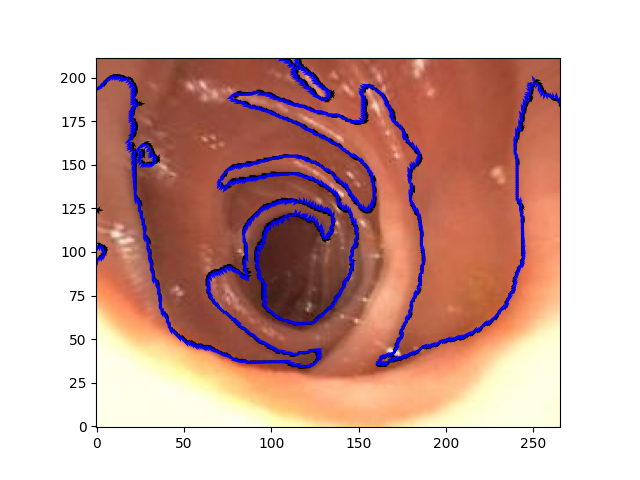

In [52]:
%matplotlib widget

locs = np.where(edges[2:-2,2:-2]>0)
tangents = np.zeros((edges.shape[0]-4, edges.shape[1]-4, 2))
for x, y in zip(locs[0], locs[1]):
    window = edges[x:x+5, y:y+5]
    if np.count_nonzero(window)<2:
        continue
    ic, jc = np.where(window==1)
    coords = np.stack((jc, ic), 0)
    mean = np.mean(coords, axis=1)
    print(mean)
    slope = np.nan_to_num((np.sum((coords[0]-mean[0])*(coords[1]-mean[1])))/np.sum((coords[0]-mean[0])**2), nan=np.inf)
    if x==98 and y==186:
        print(slope, mean)
    # slope = local_tangent(window)
    # print(slope)
    if slope is None:
        slope=np.inf
    theta = np.arctan(slope)
    tangents[x, y, 0] = np.cos(theta)
    tangents[x, y, 1] = np.sin(theta)

# X, Y = np.meshgrid(np.arange(0, tangents.shape[1], 5), np.arange(0, tangents.shape[0], 5), indexing='xy')
plt.imshow(frame[2:-2,2:-2], origin='lower')
plt.quiver(locs[1], locs[0], tangents[locs[0], locs[1], 0], tangents[locs[0], locs[1], 1], color='black')
print(tangents[98, 186])

# plt.figure()
plt.quiver(locs[1], locs[0], field[locs[0]+2, locs[1]+2, 0], field[locs[0]+2, locs[1]+2, 1], color='blue')

-0.8099767583669569


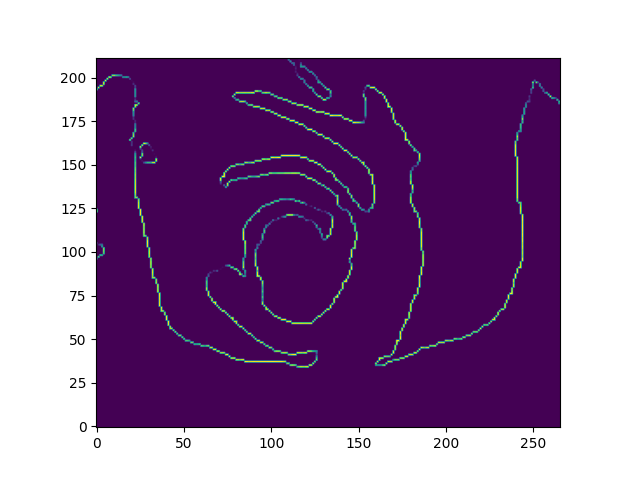

In [53]:
%matplotlib widget

field_cropped = field[2:-2,2:-2]
loss = np.abs(tangents[:,:,0]*field_cropped[:,:,0]+tangents[:,:,1]*field_cropped[:,:,1])/np.count_nonzero(np.sum(tangents**2, axis=2))
plt.imshow(loss, origin='lower')
print(-np.sum(loss))


torch.Size([1, 1, 216, 270])


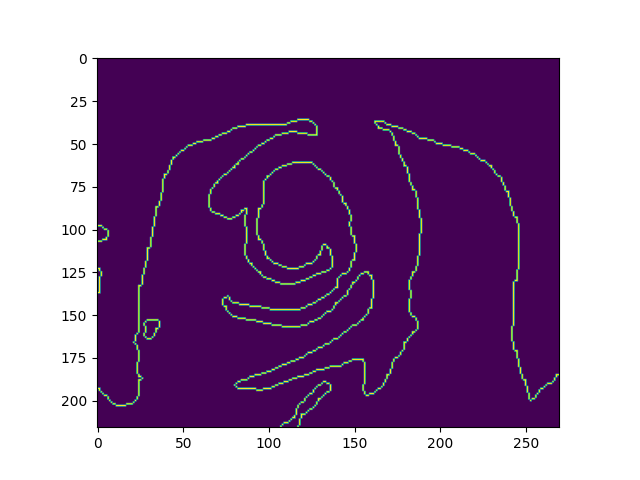

In [140]:
import torch
%matplotlib widget

im = torch.from_numpy(mask.astype(np.uint8)).int()[None,None,...]
kernel = torch.tensor([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]).reshape(1,1,3,3).int()
print(im.shape)
edges = torch.clamp(torch.nn.functional.conv2d(im, kernel, padding=(1, 1)), 0, 1)-im

plt.imshow(edges[0,0])

In [269]:
import torch
import torch.nn.functional as F
import torch.nn as nn

ks = (5,5)
edges_cropped = edges[...,2:-2, 2:-2]
unfold = nn.Unfold(kernel_size=ks)
windows = unfold(edges.float())
locs = torch.where(edges_cropped>0)
windows = windows.permute(0, 2, 1).reshape(windows.shape[0],-1,*ks)
print('windows shape:', windows.shape)

windows_on = windows[locs[0], locs[2]*edges_cropped.shape[-1]+locs[3]].int()
print(locs[3][1])
print('windows_on shape:', windows_on.shape)
print('number of edge pixels:', torch.count_nonzero(edges_cropped))

center = (113, 130)     # matrix coordinates in edges (the (216, 270) image)
print(edges[0,0,center[0]-2:center[0]+3,center[1]-2:center[1]+3])
# print(windows[0,(center[0]-2)*edges_cropped.shape[-1]+center[1]-2].int())

print(torch.nonzero((locs[2]==center[0]-2)*(locs[3]==center[1]-2)))
print(locs[3][628])
# print(windows_on[628])

counts = windows_on.sum(axis=(1,2))
ux = torch.arange(-2, 3).repeat(5,1)
uy = torch.flipud(ux.T)
mean = torch.zeros((windows_on.shape[0], 2))
mean[:,0] = (ux*windows_on).sum(axis=(1,2))/counts
mean[:,1] = (uy*windows_on).sum(axis=(1,2))/counts
print(mean[:,0].repeat(5, 5, 1).permute(2, 0, 1)[628])

xnorm = ux.repeat(len(mean), 1, 1)*windows_on - mean[:,0].repeat(5, 5, 1).permute(2, 0, 1)
ynorm = uy.repeat(len(mean), 1, 1)*windows_on - mean[:,1].repeat(5, 5, 1).permute(2, 0, 1)
Sx = xnorm.sum(axis=(1,2))
Sy = ynorm.sum(axis=(1,2))
Sxy = (xnorm*ynorm).sum(axis=(1,2))
theta = torch.arctan2(Sxy, Sx**2)
print(theta)

windows shape: torch.Size([1, 56392, 5, 5])
tensor(116)
windows_on shape: torch.Size([1532, 5, 5])
number of edge pixels: tensor(1532)
tensor([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 1, 0, 0]], dtype=torch.int32)
tensor([[628]])
tensor(128)
tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667]])
tensor([1.5708, 1.5708, 0.0000,  ..., 1.5708, 1.5708, 0.1244])


tensor([   inf,    inf,    nan,  ...,    inf,    inf, 0.1250])